# Exploratory Data Analysis with Spark

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)

In this lab, we are going to explore iRail logs of passengers’ estimations of the occupancy of Belgian trains over time.

By performing Exploratory Data Analysis (EDA) with PySpark, you will learn how to load, transform, and analyze large datasets in a distributed way. This analysis could, in theory, help estimate future train occupancy or detect usage patterns across years.

Your goal is to understand the dataset, derive meaningful statistics, and practice how to express your findings using Spark’s DataFrame API.

## Environment and Resources

To ensure everyone works in the same setup, we **recommend running this lab on Google Colab.**
Colab already includes most required packages — you just need to run the first setup cell in the notebook to make sure PySpark is correctly installed.

**Files provided:**

*   Notebook: `SparkEDA_TrainOccupancy2025.ipynb`
*   Datasets: `json_cleaned_2016.csv`, `json_cleaned_2019.csv`, `json_cleaned_2020.csv`, `json_cleaned_2022.csv`

**Before you start, please:**

1. Upload the notebook and all dataset files to your **Google Drive** (for example, inside a folder named BDT_SparkLab).

2. In Colab, mount your Drive by running the following code in the first cell:

```python
from google.colab import drive
drive.mount('/content/drive')
```

3. Once the Drive is mounted, set your file paths correctly. For example:

```python
base_dir = "/content/drive/MyDrive/BDT_SparkLab/"
# Then load your files using that path, e.g.
spark.read.csv(base_dir + "json_cleaned_2020.csv", header=True)
```

Make sure your paths are written with / (forward slashes) and **do not contain spaces or special characters**.
If you run the notebook locally instead of Colab, please ensure PySpark ≥ 3.5 and Python ≥ 3.10 are installed.

*Tip: If something looks off (e.g., missing data or strange results), print the schema and inspect a few rows before continuing.
Spark transformations are lazy — nothing happens until you trigger an action such as `.show()` or `.count()`.*

## Helpful References



* If you are new to pandas or data visualization, take a moment to review these quick guides:
    - <a href="http://pandas.pydata.org/pandas-docs/stable/10min.html"> Pandas basics in 10 minutes </a>
    - <a href="http://pandas.pydata.org/pandas-docs/stable/visualization.html"> Pandas for data visualizations </a>
    - Use the pandas cheat sheet

    Although we mainly use Spark here, understanding pandas will help you interpret Spark DataFrames more intuitively.

* For Spark, you may find these references useful:
    - <a href="http://spark.apache.org/docs/latest/programming-guide.html"> Spark programming guide</a>

    - <a  href="http://spark.apache.org/docs/latest/api/python/index.html"> Full API documentation for pySpark </a>


## Submission Guidelines

Submit **two files** to Ufora before the deadline: the executed notebook (`.ipynb`) and the exported HTML version (`.html`) showing all outputs and answers. Name both files with your full name, for example:
`FirstnameLastname_SparkLab.ipynb` and `FirstnameLastname_SparkLab.html`.
Do not include any raw `.csv` data files.


---


**How to export to HTML (in Google Colab)**
Before exporting, make sure your Google Drive is mounted in Colab.
After all cells have been executed and outputs are visible, run the command below (adjust the path to your own Drive folder):

```python
!jupyter nbconvert --to html "/content/drive/MyDrive/BDT_SparkLab/FirstnameLastname_SparkLab.ipynb"
```
This will create an HTML file in the same folder as your notebook. You can find it in the Files panel on the left and download it to your computer.


---


*Tip: open your exported HTML file in a browser before submission to ensure all results and plots display correctly.Make sure your notebook runs without errors and that every required section is completed.*

**Deadline: Friday, 24 October 2025, 11:59 PM**

For any questions or technical issues, contact the lab assistant - Fei, at least **2–3 days before the deadline**: fei.fei@ugent.be

## Important Information

* Each question in this notebook should be answered **with working code and visible outputs** such as tables or charts.
Keep your code clean and readable, and add concise comments where necessary.
After each task, write a **short Markdown answer (1–3 sentences)** summarizing your observations or conclusions.

* Always provide references if you use external code or tutorials other than the official PySpark or pandas documentation.

* Remember that Google Colab does not save execution results. Every time you reopen the notebook, you must re-run all cells before exporting or submitting.

* Use relative paths (e.g., `base_dir + "json_cleaned_2020.csv"`) when reading data. Do not modify or move the original dataset files. If you need to save temporary or processed outputs, store them in a subfolder (e.g., /spark_out_eda/) rather than modifying the data folder.

* Double-check that all figures and tables are visible in the exported HTML file.

* We will deduct points for: missing outputs, incomplete answers, wrong file naming, broken code, incorrect submission format, or any form of **plagiarism**.

## Start the Lab

First we will import the necessary libraries, and install PySpark.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#vector/matrix library
import numpy as np
#data frame library (similar to R)
import pandas as pd

#visualization library
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#check availability in colab
try:
    import pyspark
except Exception:
    !pip -q install pyspark==3.5.2

In [3]:
import pyspark
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName("Our First Spark Example") \
    .getOrCreate()

spark

Now we input our data file into a data structure.



In [7]:
# Define the base directory
base_dir = "/content/drive/MyDrive/BDT_SparkLab/"

# List of files to combine
csv_files = ['json_cleaned_2016.csv', 'json_cleaned_2019.csv', 'json_cleaned_2020.csv', 'json_cleaned_2022.csv']

# Define the expected column order
expected_columns = ['querytime', 'from', 'to', 'occupancy', 'train_series', 'train_direction', 'train_type']

# Read and combine the CSV files, applying initial filtering
combined_df = None
valid_occupancy_values = ['low', 'medium', 'high']


for file in csv_files:
    file_path = base_dir + file

    # Read CSV file
    df_temp = spark.read.csv(file_path, header=True, inferSchema=True)


    # Drop the 'id' column if it exists
    if 'id' in df_temp.columns:
        df_temp = df_temp.drop('id')

    # Reorder columns to match expected order (only select columns that exist)
    available_columns = [col for col in expected_columns if col in df_temp.columns]
    df_temp = df_temp.select(available_columns)


    # Filter out invalid data:
    # 1. Keep only valid occupancy values (low, medium, high)
    # 2. Remove rows where train_type is None or null
    # 3. Remove rows where occupancy is None or null
    df_temp = df_temp.filter(
        (F.col('occupancy').isin(valid_occupancy_values)) &
        (F.col('train_type').isNotNull()) &
        (F.col('train_type') != 'None') &
        (F.col('train_type') != '') &
        (F.col('querytime').isNotNull()) &
        (F.col('from').isNotNull()) &
        (F.col('to').isNotNull())
    )



    # Union with combined dataframe
    if combined_df is None:
        combined_df = df_temp
    else:
        combined_df = combined_df.union(df_temp)

# Show summary statistics
print("=" * 60)
print("=== Combined Dataset Summary ===")
print("=" * 60)
print(f"Total records after combining and cleaning: {combined_df.count()}")
print(f"\nColumn order in final dataset:")
print(combined_df.columns)
print(f"\nSchema:")
combined_df.printSchema()

print("\nSample data:")
combined_df.show(10, truncate=False)

# Verify occupancy distribution (should only show low, medium, high)
print("\n=== Occupancy Distribution (should only be low/medium/high) ===")
occupancy_dist = combined_df.groupBy('occupancy').count().orderBy('occupancy')
occupancy_dist.show()

# Check if there are any unexpected values
unexpected_occupancy = combined_df.filter(~F.col('occupancy').isin(valid_occupancy_values)).count()
print(f"\nRows with unexpected occupancy values: {unexpected_occupancy}")

# Verify train_type distribution
print("\n=== Train Type Distribution ===")
combined_df.groupBy('train_type').count().orderBy(F.desc('count')).show()

# Check for any remaining null values
null_counts = combined_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in combined_df.columns])

# Verify data types are consistent

combined_df.select('from', 'to', 'occupancy').dtypes

# Optional: Save the cleaned combined dataset
save_cleaned_data = False  # Set to True if you want to save

if save_cleaned_data:
    output_path = base_dir + 'json_entire_dataset_cleaned.csv'
    combined_df.coalesce(1).write.csv(output_path, header=True, mode='overwrite')
    print("Data saved successfully!")

# Create the final DataFrame and RDD for analysis
print("\n" + "=" * 60)
print("=== Creating final DataFrame and RDD ===")
print("=" * 60)
df = combined_df
rdd = df.rdd

print(f"DataFrame ready with {df.count()} records")
print(f"RDD ready with {rdd.count()} records")


=== Combined Dataset Summary ===
Total records after combining and cleaning: 7930

Column order in final dataset:
['querytime', 'from', 'to', 'occupancy', 'train_series', 'train_direction', 'train_type']

Schema:
root
 |-- querytime: timestamp (nullable = true)
 |-- from: integer (nullable = true)
 |-- to: integer (nullable = true)
 |-- occupancy: string (nullable = true)
 |-- train_series: integer (nullable = true)
 |-- train_direction: string (nullable = true)
 |-- train_type: string (nullable = true)


Sample data:
+-------------------+-------+-------+---------+------------+---------------+----------+
|querytime          |from   |to     |occupancy|train_series|train_direction|train_type|
+-------------------+-------+-------+---------+------------+---------------+----------+
|2016-07-27 21:41:46|8812005|8822004|high     |4500        |away           |IC        |
|2016-07-27 22:04:25|8831765|8831765|low      |1500        |back           |IC        |
|2016-07-27 22:18:09|8831765|8813003

In [8]:
df
# Filter out rows where train_type is null or 'None'
df = df.filter(df.train_type.isNotNull() & (df.train_type != 'None'))

df.show(5)
rdd = df.rdd

+-------------------+-------+-------+---------+------------+---------------+----------+
|          querytime|   from|     to|occupancy|train_series|train_direction|train_type|
+-------------------+-------+-------+---------+------------+---------------+----------+
|2016-07-27 21:41:46|8812005|8822004|     high|        4500|           away|        IC|
|2016-07-27 22:04:25|8831765|8831765|      low|        1500|           back|        IC|
|2016-07-27 22:18:09|8831765|8813003|      low|        1500|           back|        IC|
|2016-07-27 22:38:28|8819406|8812005|     high|        3600|           back|        IC|
|2016-07-28 06:50:27|8892007|8813003|   medium|        1500|           away|        IC|
+-------------------+-------+-------+---------+------------+---------------+----------+
only showing top 5 rows



**About the Dataset**

This dataset is intended to be used to predict future occupancy on Belgian trains based on previously collected information about train occupancy. iRail asked train travelers to report the occupancy of particular trains through a public API. We have a `querytime` column, which shows when a user used the API to enter the occupancy of a particular train. The `occupancy` value is either low, medium, or high. The `from` and `to` columns indicate the stations where the passenger got on and off the train (so these are not the first and last stations of the train route). We also have the `train_type`, `train_series`, and `train_direction` columns. The train_series identifies the route of the Belgian railways. For example, series 500 always goes from Oostende to Eupen. Adding 25 gives you the train in the opposite direction, meaning 525 goes from Eupen to Oostende.

## Section 1. Analyzing the data columns.

### Number of logs  

**1a. How many logs are contained in the file?**

In [9]:
number_logs = (rdd.count())
print(f"Answer: we have {number_logs} logs in the cleaned data."  )

Answer: we have 7930 logs in the cleaned data.


### Occupancy Distribution

**1b. Make a pie chart showing the distrubution of occupancy.** Are the categories uniformly distributed?

HINT: use the pandas plot function for pie charts.

Answer: 
  occupancy  count
0      high   2662
1       low   3062
2    medium   2206


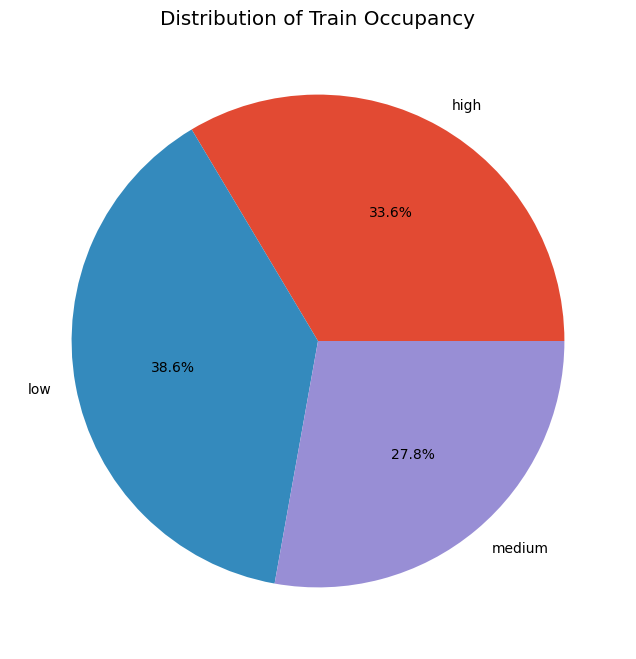

In [10]:
num_per_occupancy = (df.groupBy('occupancy')
                      .count()
                      .orderBy('occupancy')
                      .toPandas())

print("Answer: \n" + str(num_per_occupancy))

# Create pie chart
num_per_occupancy.set_index('occupancy')['count'].plot(kind='pie',
                                                         autopct='%1.1f%%',
                                                         figsize=(8, 8))
plt.title('Distribution of Train Occupancy')
plt.ylabel('')
plt.show()

The pie chart illustrates that the distribution of occupancy is nearly uniform.

### Train Type Distrubtion

**1c. Make a pie chart showing the distribution of the train types.**

Answer: 
   train_type  count
0          IC   5180
1           S   1315
2           P    759
3           L    575
4         THA     46
5         ICT     15
6         ICE      9
7           T      9
8         TGV      8
9         EUR      5
10        EXT      4
11        TRN      3
12        BUS      2


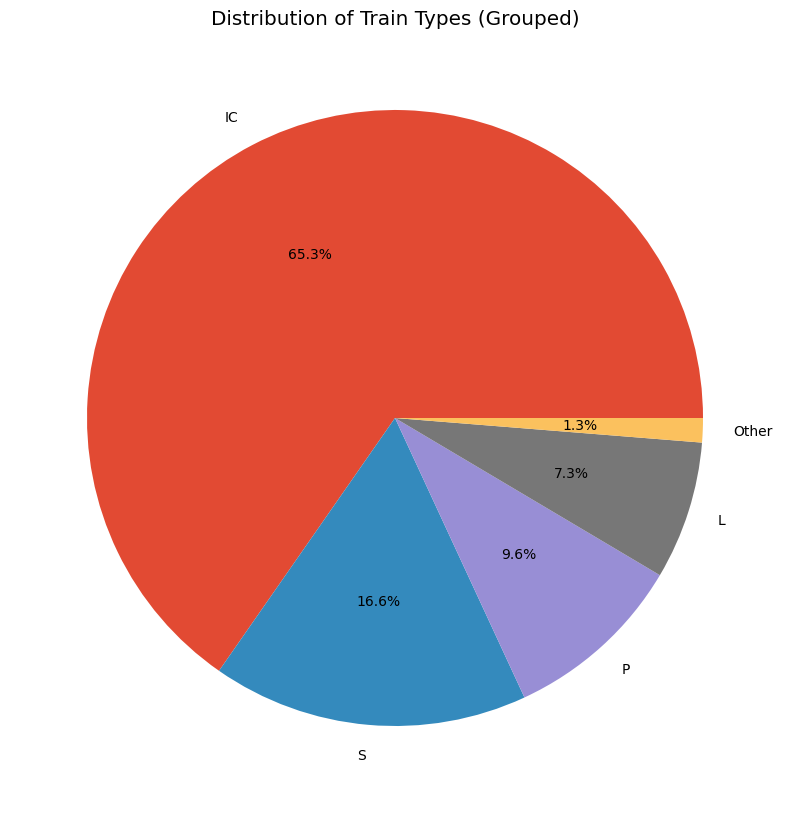

In [11]:
# Calculate counts for all train types
num_per_traintype = (df.groupBy('train_type')
                       .count()
                       .orderBy('count', ascending=False)
                       .toPandas())

print("Answer: \n" + str(num_per_traintype))

# Define major train types
major_train_types = ['IC', 'S', 'P', 'L']

# Categorize train types into major and 'Other'
df_categorized = df.withColumn('train_type_grouped',
                               F.when(df.train_type.isin(major_train_types), df.train_type)
                               .otherwise('Other'))

# Calculate counts for the grouped train types
num_per_traintype_grouped = (df_categorized.groupBy('train_type_grouped')
                                .count()
                                .orderBy('count', ascending=False)
                                .toPandas())

# Create pie chart for grouped train type distribution with a legend
fig, ax = plt.subplots(figsize=(10, 10))
num_per_traintype_grouped.set_index('train_type_grouped')['count'].plot(kind='pie',
                                                                          autopct='%1.1f%%',
                                                                          ax=ax)
ax.set_title('Distribution of Train Types (Grouped)')
ax.set_ylabel('')
plt.show()

### Number of months

**1d. How many different months and years do your logs cover?**

Tip: First write a function to extract the month and year from the query time.

Tip2: The query time is of type datetime.

In [16]:
def extractMonthYear(slt):
    querytime = slt['querytime']
    return querytime.strftime('%Y-%m')

def extractMonth(row):
    querytime = row['querytime']
    return querytime.strftime('%m')  # Returns month as '01', '02', etc.

def extractYear(row):
    querytime = row['querytime']
    return querytime.year  # Returns year as an integer

In [18]:
months = (rdd.map(extractMonthYear)
          .distinct()
          .collect())

print("Answer: " + str(len(months)) + " different months: " + str(sorted(months)))

months_years = (rdd.map(extractMonthYear)
                .distinct()
                .collect())

# Get unique months (regardless of year)
unique_months = (rdd.map(extractMonth)
                 .distinct()
                 .collect())

# Get unique years
unique_years = (rdd.map(extractYear)
                .distinct()
                .collect())

# Convert month numbers to names for better readability
month_names = {
    '01': 'January', '02': 'February', '03': 'March', '04': 'April',
    '05': 'May', '06': 'June', '07': 'July', '08': 'August',
    '09': 'September', '10': 'October', '11': 'November', '12': 'December'
}

unique_month_names = [month_names[m] for m in unique_months_sorted]


# Sort the results
months_years_sorted = sorted(months_years)
unique_months_sorted = sorted(unique_months)
unique_years_sorted = sorted(unique_years)

print(f"\n\nUnique YEARS covered: {len(unique_years_sorted)}")
print(f"Years: {unique_years_sorted}")

print(f"\n\nUnique MONTHS covered: {len(unique_months_sorted)}")
print(f"Months (numbers): {unique_months_sorted}")
print(f"Months (names): {unique_month_names}")

Answer: 28 different months: ['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11']


Unique YEARS covered: 5
Years: [2016, 2017, 2019, 2020, 2022]


Unique MONTHS covered: 12
Months (numbers): ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Months (names): ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


## Section 2. Exploring the data in depth based on time

### Logs per month

**2a. How many logs per month were recorded?  Visualize this in a bar graph.  Make sure the bar graph's x axis is sorted chronologically.**

Tip: Convert the *requests_per_month* variable to a pandas Dataframe to graph the data.

Answer: [('2016-07', 73), ('2016-08', 193), ('2016-09', 778), ('2016-10', 1181), ('2016-11', 972), ('2016-12', 471), ('2017-01', 551), ('2017-02', 646), ('2019-01', 347), ('2019-02', 201), ('2019-03', 212), ('2019-04', 293), ('2019-05', 293), ('2019-06', 289), ('2019-07', 265), ('2019-08', 249), ('2019-09', 317), ('2019-10', 108), ('2019-11', 231), ('2019-12', 99), ('2020-01', 3), ('2022-05', 2), ('2022-06', 6), ('2022-07', 5), ('2022-08', 69), ('2022-09', 12), ('2022-10', 12), ('2022-11', 52)]


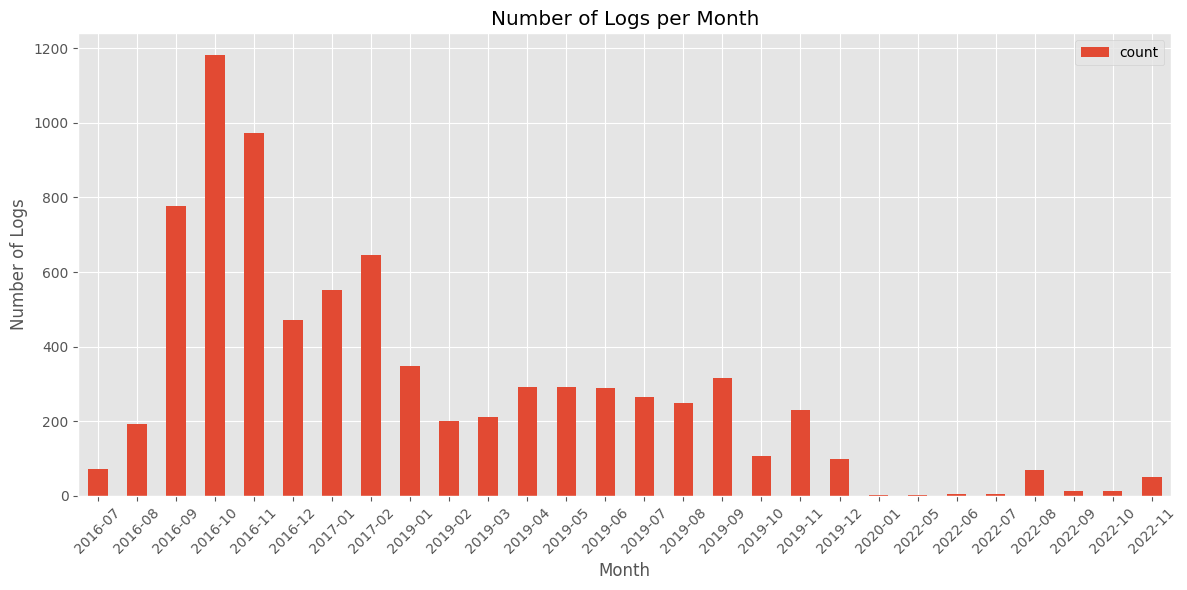

In [19]:
requests_per_month = (rdd.map(lambda row: (extractMonthYear(row), 1))
                       .reduceByKey(lambda a, b: a + b)
                       .sortByKey()
                       .collect())

print("Answer: " + str(requests_per_month))

# Convert to pandas and plot
df_month = pd.DataFrame(requests_per_month, columns=['month', 'count'])
df_month.plot(x='month', y='count', kind='bar', figsize=(12, 6))
plt.title('Number of Logs per Month')
plt.xlabel('Month')
plt.ylabel('Number of Logs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== BONUS: Logs per Calendar Month (aggregated) ===



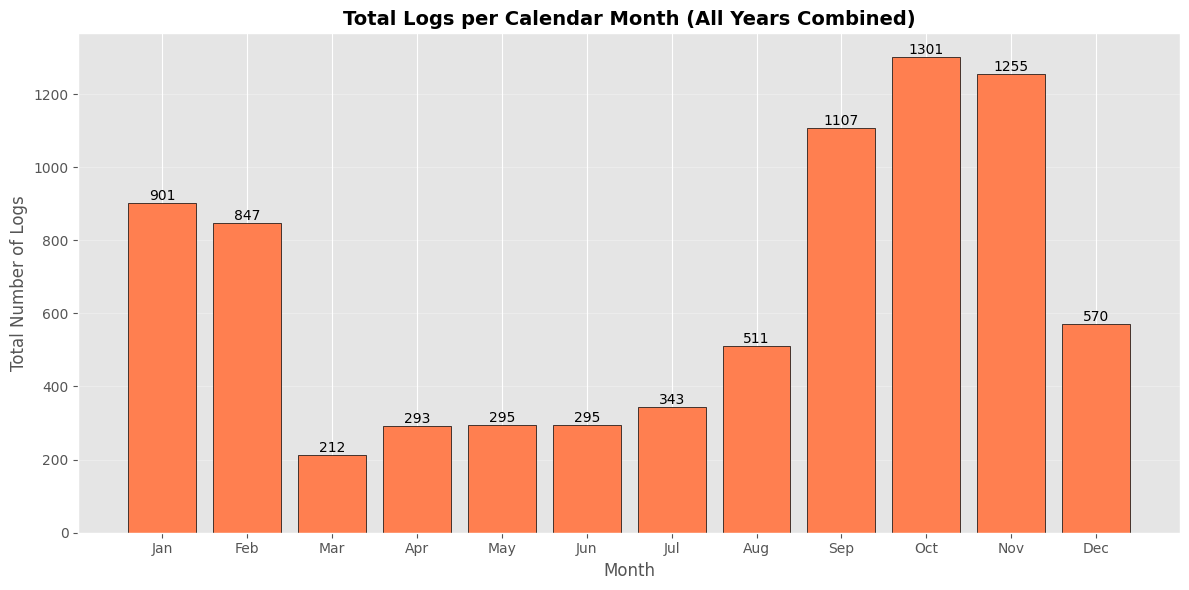

   month_name  count
0         Jan    901
1         Feb    847
2         Mar    212
3         Apr    293
4         May    295
5         Jun    295
6         Jul    343
7         Aug    511
8         Sep   1107
9         Oct   1301
10        Nov   1255
11        Dec    570


In [20]:
# Logs per calendar month (aggregated across years)
print("\n=== Logs per Calendar Month (aggregated) ===\n")

def extractMonthOnly(row):
    return row['querytime'].strftime('%m')  # Just month number

requests_per_calendar_month = (rdd.map(lambda row: (extractMonthOnly(row), 1))
                                .reduceByKey(lambda a, b: a + b)
                                .sortByKey()
                                .collect())

# Convert to month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_calendar_month = pd.DataFrame(requests_per_calendar_month, columns=['month_num', 'count'])
df_calendar_month['month_name'] = df_calendar_month['month_num'].apply(lambda x: month_names[int(x)-1])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_calendar_month['month_name'], df_calendar_month['count'],
        color='coral', edgecolor='black')
plt.title('Total Logs per Calendar Month (All Years Combined)', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Number of Logs', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (month, count) in enumerate(zip(df_calendar_month['month_name'], df_calendar_month['count'])):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(df_calendar_month[['month_name', 'count']])

### Logs per day of the week

**2b. Plot the number of records per day of the week.**  

What does this chart teach you?

Tip: Look at [the API of date objects in Python](https://docs.python.org/3/library/datetime.html#date-objects).


Answer: [(0, 1362), (1, 1393), (2, 1305), (3, 1398), (4, 1236), (5, 527), (6, 709)]


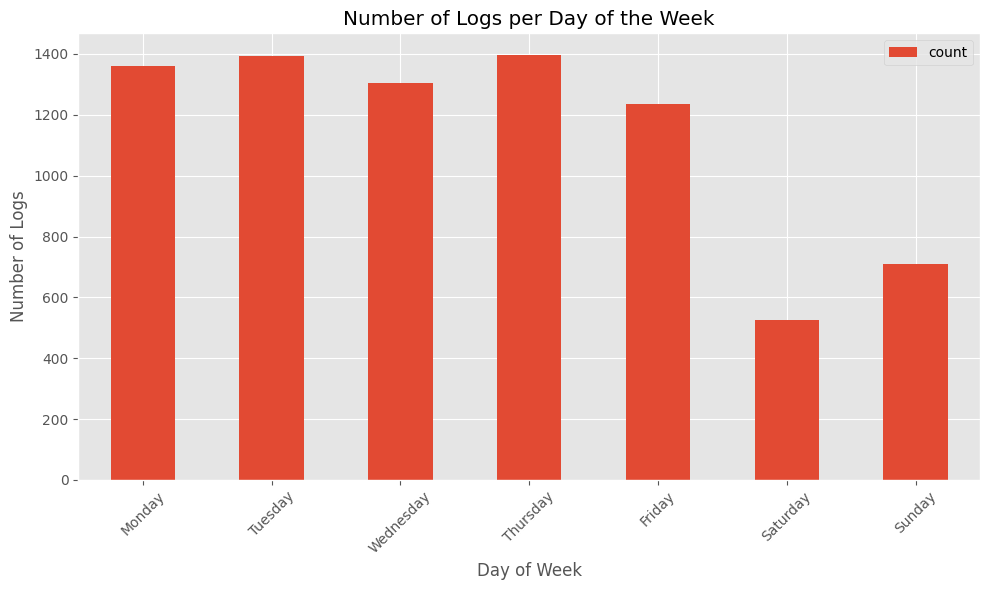

In [21]:
data_per_weekday = (rdd.map(lambda row: (row['querytime'].weekday(), 1))
                     .reduceByKey(lambda a, b: a + b)
                     .sortByKey()
                     .collect())

print("Answer: " + str(data_per_weekday))

# Convert to pandas and plot
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekday = pd.DataFrame(data_per_weekday, columns=['day', 'count'])
df_weekday['day_name'] = df_weekday['day'].apply(lambda x: weekday_names[x])

df_weekday.plot(x='day_name', y='count', kind='bar', figsize=(10, 6))
plt.title('Number of Logs per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Logs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Answer: The chart shows higher activity on weekdays compared to weekends, indicating more train usage during working days.

### Logs per hour

**2c. Visualize the distribution over hour of the day**

What do you observe?


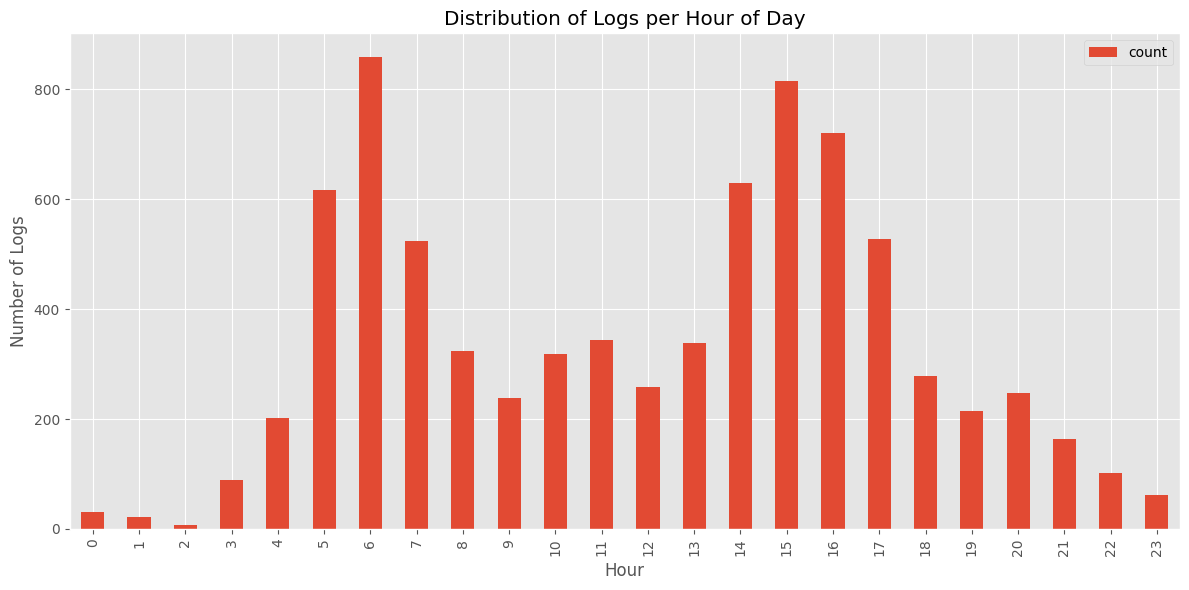

In [22]:
data_per_hour = (rdd.map(lambda row: (row['querytime'].hour, 1))
                  .reduceByKey(lambda a, b: a + b)
                  .sortByKey()
                  .collect())

# Convert to pandas and plot
df_hour = pd.DataFrame(data_per_hour, columns=['hour', 'count'])
df_hour.plot(x='hour', y='count', kind='bar', figsize=(12, 6))
plt.title('Distribution of Logs per Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Logs')
plt.tight_layout()
plt.show()

Answer: The distribution shows clear peaks during morning (5-8 AM) and evening (2-5 pm) rush hours, corresponding to commuting patterns.

### Distribution for weekdays and weekend days

**2d. Plot this distribution separately for weekdays, Saturdays and Sundays.**
  
Can you identify some patterns of travel based on the day?


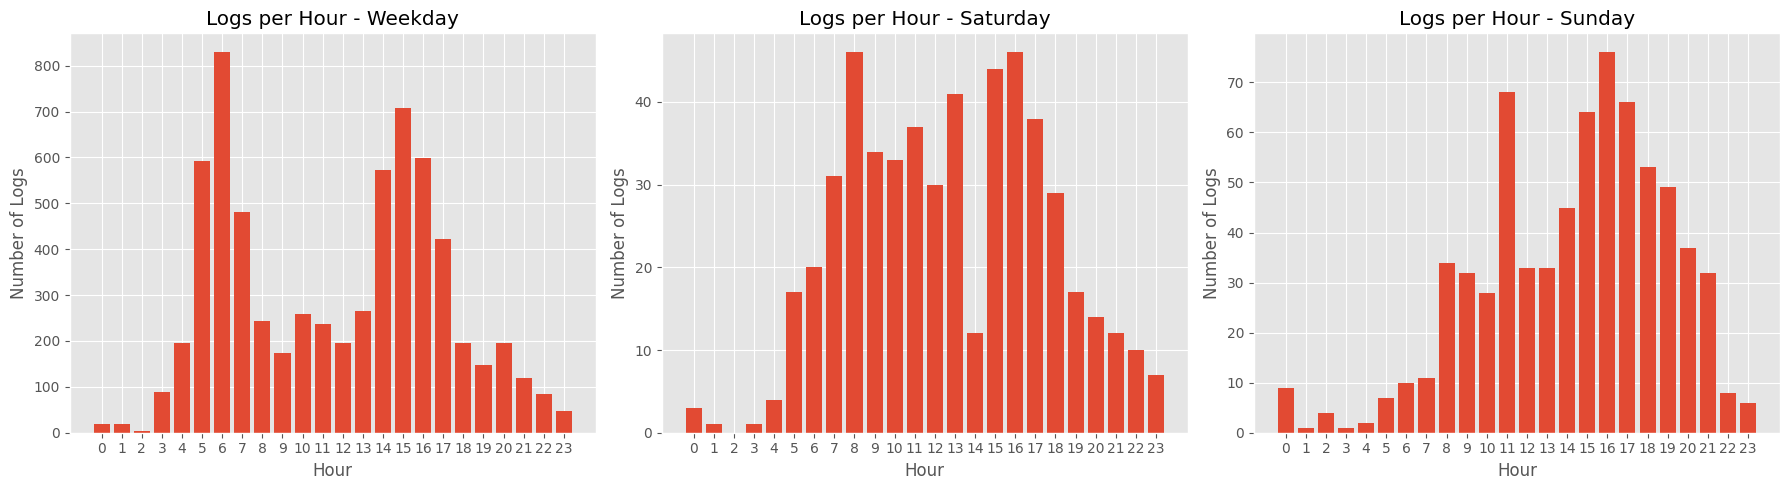

In [23]:
def categorize_day(row):
    weekday = row['querytime'].weekday()
    hour = row['querytime'].hour
    if weekday < 5:
        return ('Weekday', hour)
    elif weekday == 5:
        return ('Saturday', hour)
    else:
        return ('Sunday', hour)

data_per_day_category = (rdd.map(lambda row: (categorize_day(row), 1))
                          .reduceByKey(lambda a, b: a + b)
                          .map(lambda x: (x[0][0], x[0][1], x[1]))
                          .collect())

# Convert to pandas and plot
df_day_cat = pd.DataFrame(data_per_day_category, columns=['day_type', 'hour', 'count'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, day_type in enumerate(['Weekday', 'Saturday', 'Sunday']):
    data = df_day_cat[df_day_cat['day_type'] == day_type].sort_values('hour')
    axes[i].bar(data['hour'], data['count'])
    axes[i].set_title(f'Logs per Hour - {day_type}')
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Number of Logs')
    axes[i].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

Answer: Weekdays show clear rush hour peaks, while Saturdays and Sundays are different. Sundays have more evenly distributed usage throughout the day with peaks during afternoon hours, while Saturdays have more rush hours than even weekdays.


### Visualize the seasons separately

<b>2e. Create a plot for the number of records per hour on weekdays separately for [April, October] and [November, March] </b>

What do you think that is happening? How would you fix it?

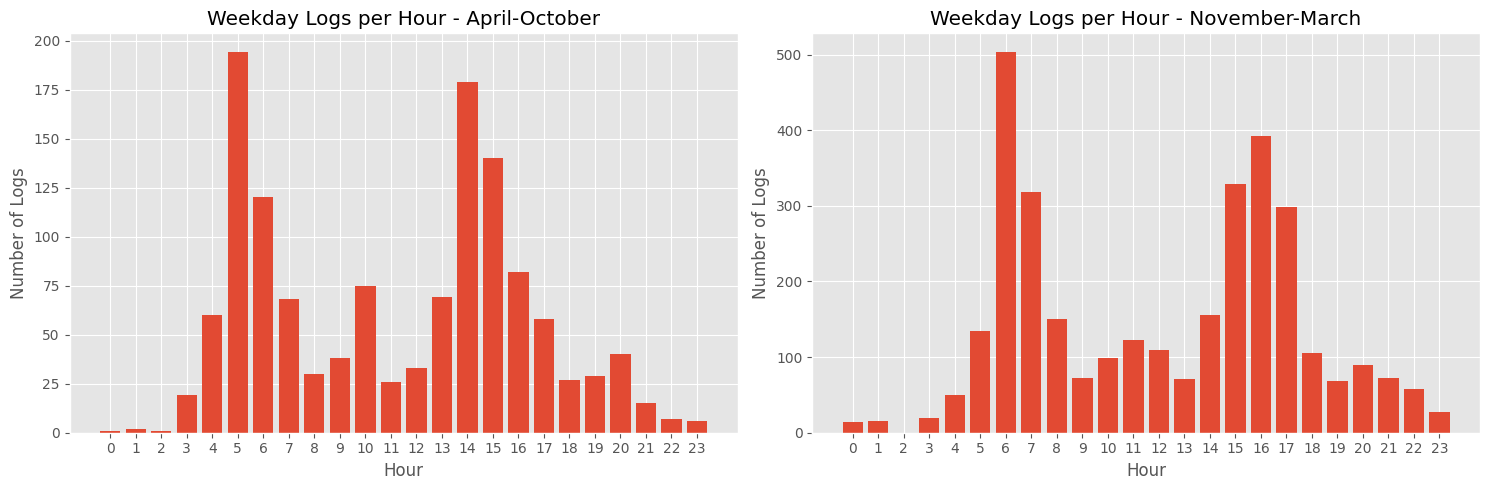

In [25]:
def get_season_hour(row):
    month = row['querytime'].month
    hour = row['querytime'].hour
    weekday = row['querytime'].weekday()

    if weekday < 5:  # Only weekdays
        if month in [4, 10]:
            return ('April-October', hour)
        elif month in [11, 12, 1, 2, 3]:
            return ('November-March', hour)
    return None

season_data = (rdd.map(lambda row: (get_season_hour(row), 1))
               .filter(lambda x: x[0] is not None)
               .reduceByKey(lambda a, b: a + b)
               .map(lambda x: (x[0][0], x[0][1], x[1]))
               .collect())

# Plot
df_season = pd.DataFrame(season_data, columns=['season', 'hour', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, season in enumerate(['April-October', 'November-March']):
    data = df_season[df_season['season'] == season].sort_values('hour')
    axes[i].bar(data['hour'], data['count'])
    axes[i].set_title(f'Weekday Logs per Hour - {season}')
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Number of Logs')
    axes[i].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

## Section 3. Exploring the data in depth in regards to relationships between features

### Occupancy dependence upon train type

**3a. How does the occupancy depend on the train type? Visualize using a normalized stacked bar chart.**


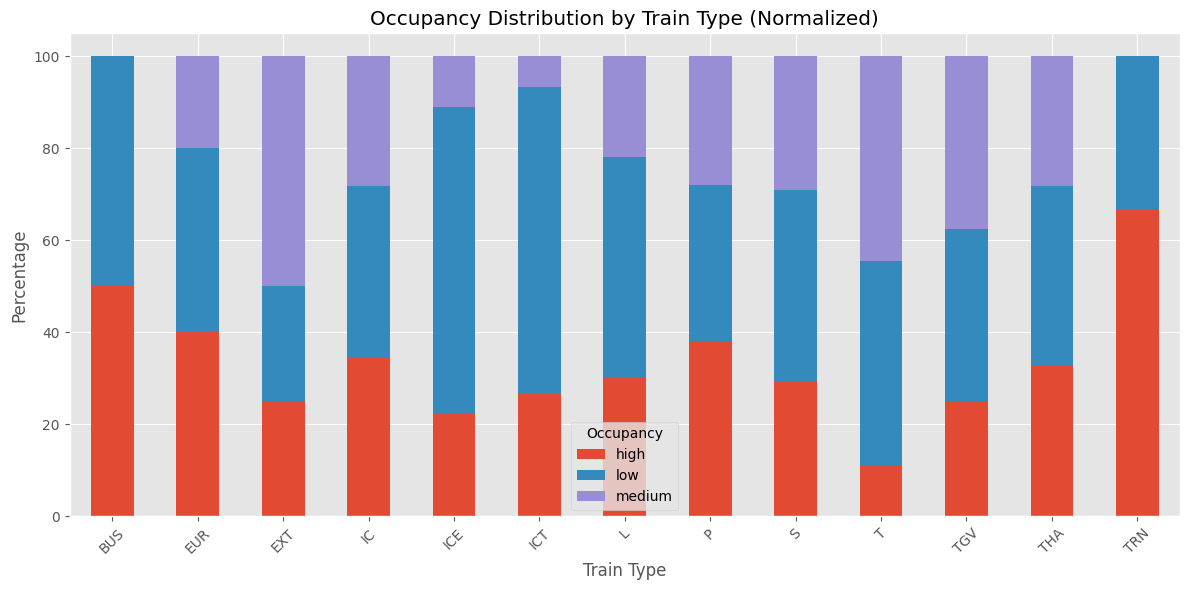

In [27]:
occupancy_by_train = (df.groupBy('train_type', 'occupancy')
                       .count()
                       .toPandas())

# Pivot for stacked bar chart
pivot_data = occupancy_by_train.pivot(index='train_type', columns='occupancy', values='count').fillna(0)

# Normalize
pivot_normalized = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

pivot_normalized.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Occupancy Distribution by Train Type (Normalized)')
plt.xlabel('Train Type')
plt.ylabel('Percentage')
plt.legend(title='Occupancy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Occupancy dependence upon month

**3b. How does the occupancy vary per month?**


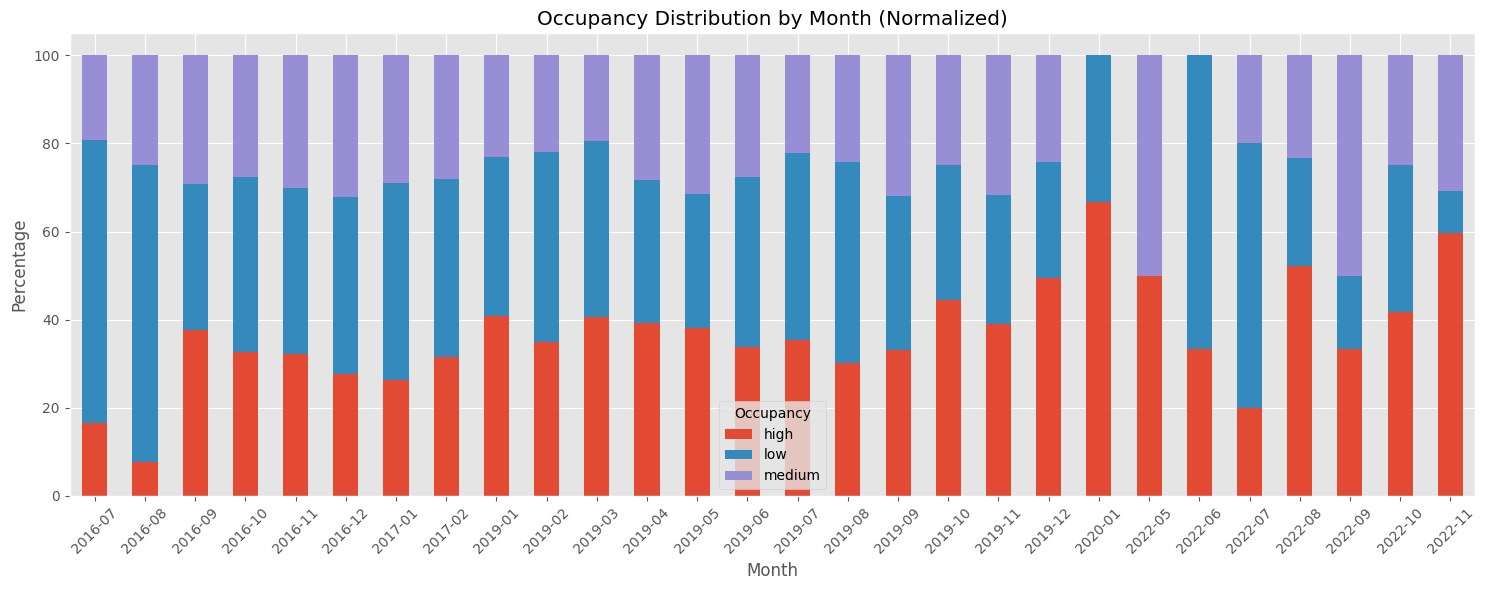

In [28]:
df_with_month = df.withColumn('month', F.date_format('querytime', 'yyyy-MM'))

occupancy_by_month = (df_with_month.groupBy('month', 'occupancy')
                       .count()
                       .toPandas())

pivot_month = occupancy_by_month.pivot(index='month', columns='occupancy', values='count').fillna(0)
pivot_month_norm = pivot_month.div(pivot_month.sum(axis=1), axis=0) * 100

pivot_month_norm.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Occupancy Distribution by Month (Normalized)')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(title='Occupancy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Occupancy dependence upon weekday

**3c. How does the occupancy vary per weekday?**


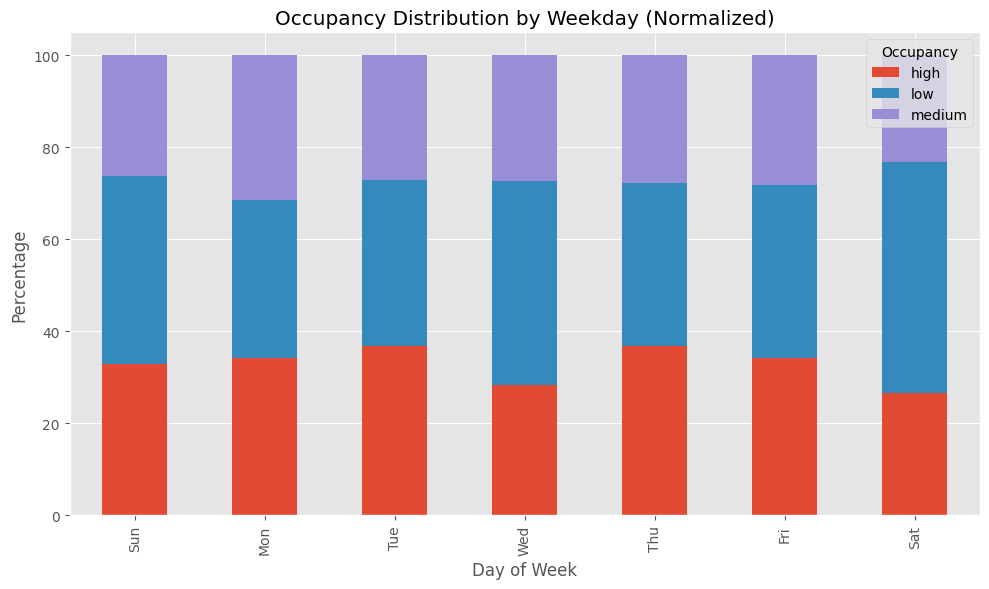

In [29]:
df_with_weekday = df.withColumn('weekday', F.dayofweek('querytime'))

occupancy_by_weekday = (df_with_weekday.groupBy('weekday', 'occupancy')
                         .count()
                         .toPandas())

pivot_weekday = occupancy_by_weekday.pivot(index='weekday', columns='occupancy', values='count').fillna(0)
pivot_weekday_norm = pivot_weekday.div(pivot_weekday.sum(axis=1), axis=0) * 100

weekday_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
pivot_weekday_norm.index = [weekday_labels[int(i)-1] for i in pivot_weekday_norm.index]

pivot_weekday_norm.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Occupancy Distribution by Weekday (Normalized)')
plt.xlabel('Day of Week')
plt.ylabel('Percentage')
plt.legend(title='Occupancy')
plt.tight_layout()
plt.show()

### Occupancy dependence upon hour

**3d. How does the occupancy vary per hour (distinguish between weekday, Saturday, Sunday)?**

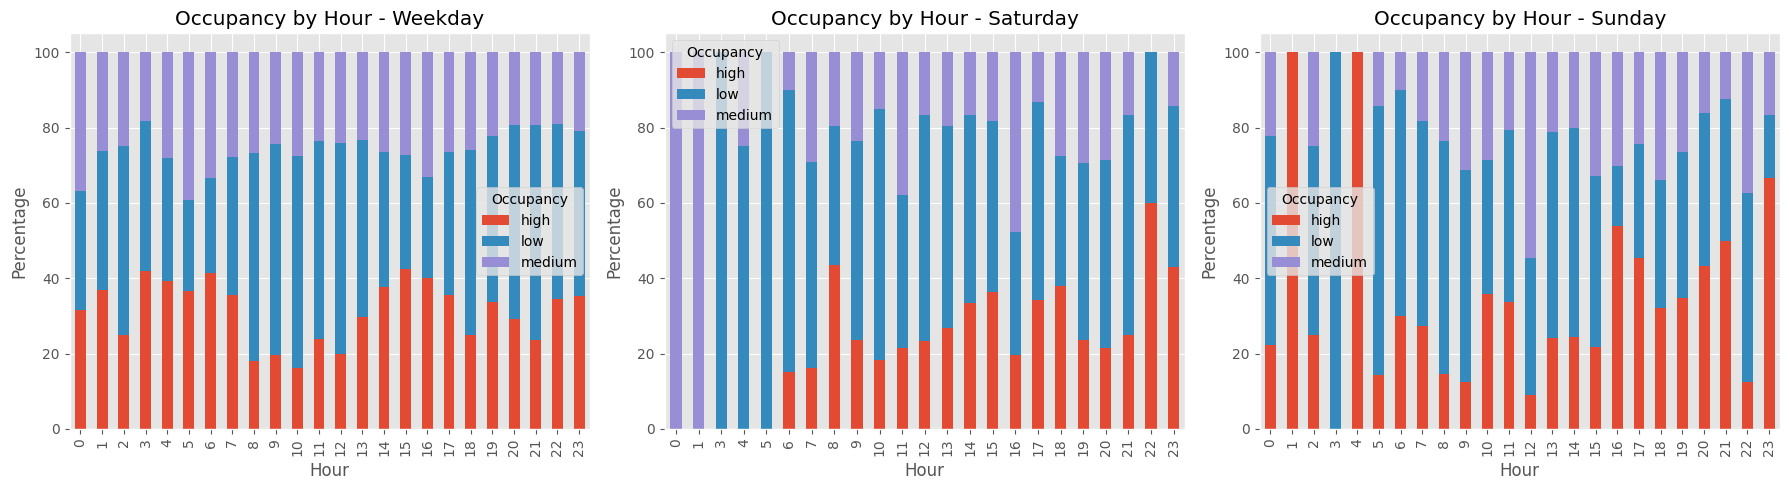

In [30]:
df_with_hour = df.withColumn('hour', F.hour('querytime')).withColumn('weekday', F.dayofweek('querytime'))

df_with_day_type = df_with_hour.withColumn(
    'day_type',
    F.when(F.col('weekday').between(2, 6), 'Weekday')
     .when(F.col('weekday') == 7, 'Saturday')
     .otherwise('Sunday')
)

occupancy_by_hour_day = (df_with_day_type.groupBy('day_type', 'hour', 'occupancy')
                          .count()
                          .toPandas())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, day_type in enumerate(['Weekday', 'Saturday', 'Sunday']):
    data = occupancy_by_hour_day[occupancy_by_hour_day['day_type'] == day_type]
    pivot = data.pivot(index='hour', columns='occupancy', values='count').fillna(0)
    pivot_norm = pivot.div(pivot.sum(axis=1), axis=0) * 100

    pivot_norm.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Occupancy by Hour - {day_type}')
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(title='Occupancy')

plt.tight_layout()
plt.show()

## Section 4. Open Questions

**4.1 What other analysis with this data would be useful to reveal new insights?  Perform one extra exploratory calculation and produce one extra graph, using the station (from or to columns) or route (train_series column) information.**

Tip: Here is a [link to an explanation of train catgories in Belgium](https://nl.wikipedia.org/wiki/Lijst_van_treincategorie%C3%ABn_in_Belgi%C3%AB)  (in Dutch).

Here is a [csv file that maps station identifiers to names, latitudes, longitudes, etc.](https://github.com/iRail/stations/blob/master/stations.csv)


=== Temporal Patterns of Top 3 Routes ===


Route: 8892007 → 8814001


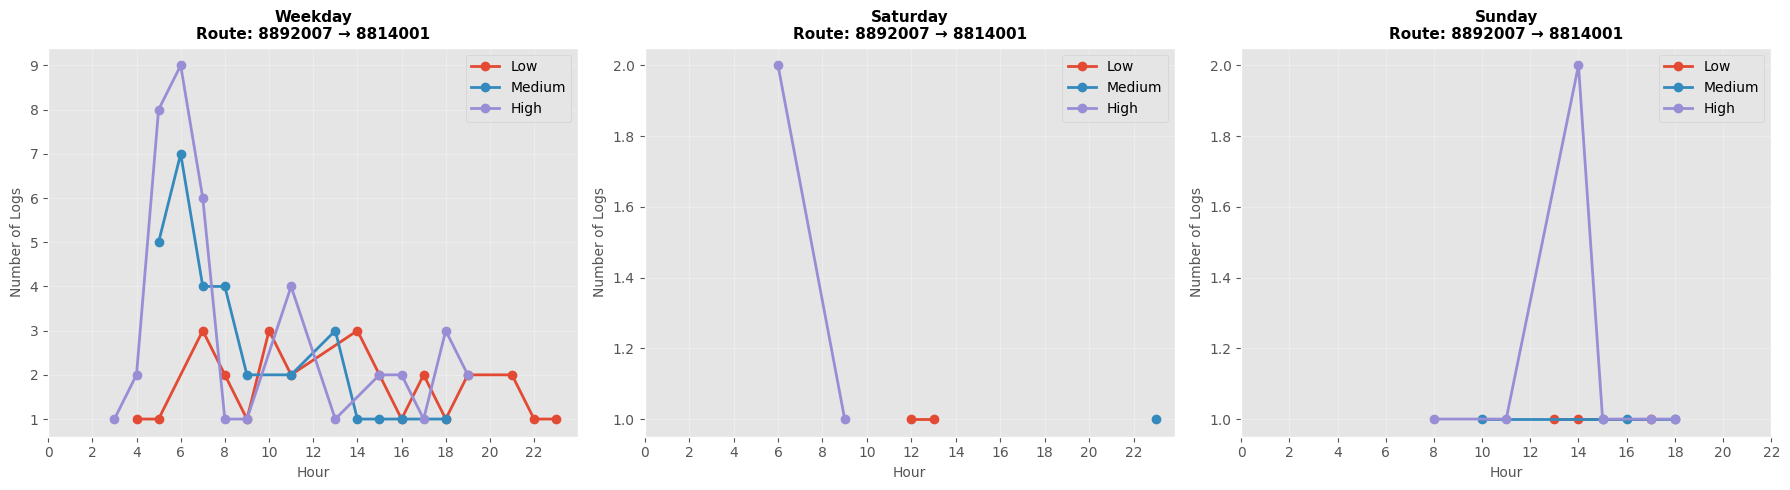


Route: 8813003 → 8814001


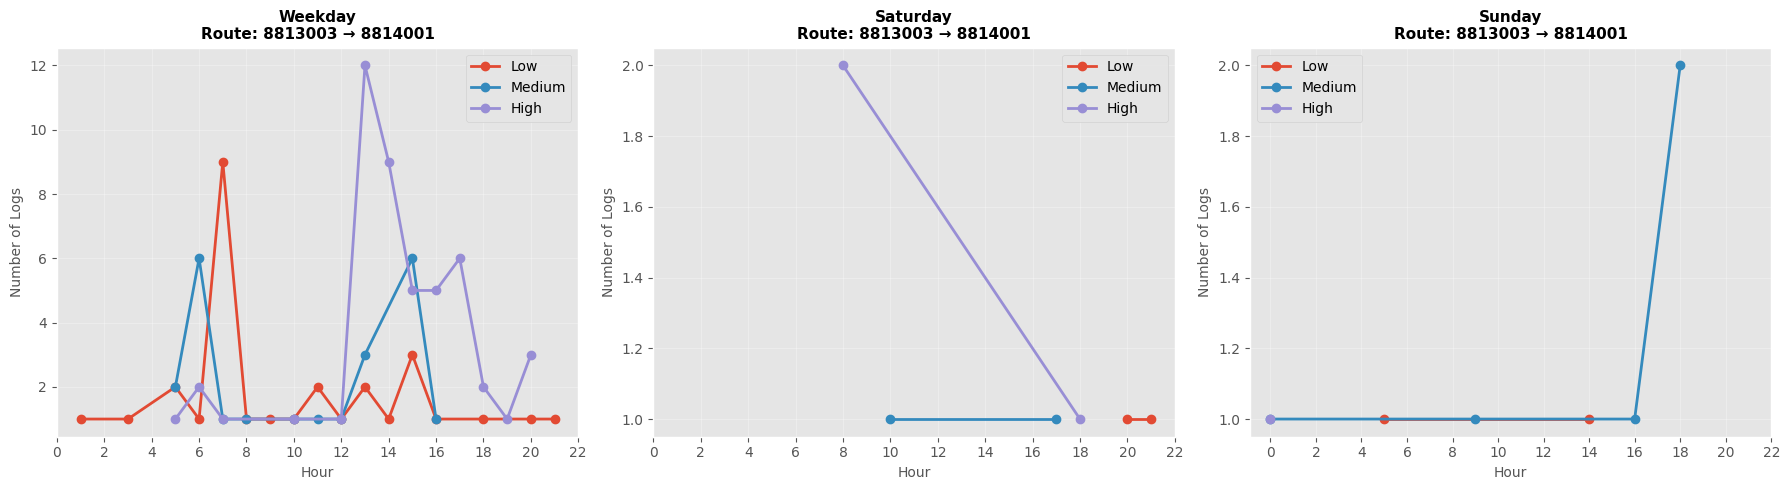


Route: 8812005 → 8813003


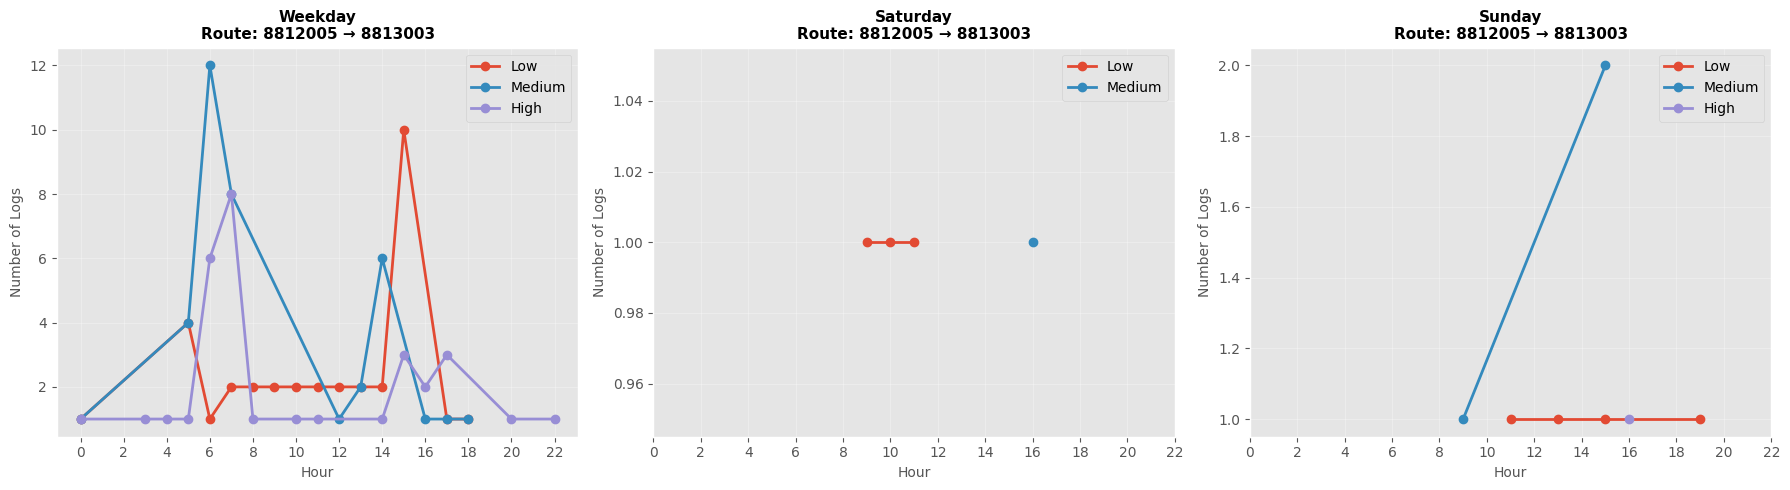


✓ Bonus analysis complete!


In [33]:
# Deep dive into specific popular routes

# Create route pairs and count
route_popularity = (df.groupBy('from', 'to')
                     .count()
                     .orderBy(F.desc('count'))
                     .limit(20))

route_popularity_pd = route_popularity.toPandas()

# Create readable route labels
route_popularity_pd['route'] = (route_popularity_pd['from'].astype(str) +
                                 ' → ' +
                                 route_popularity_pd['to'].astype(str))

print("\n=== Temporal Patterns of Top 3 Routes ===\n")

# Get top 3 routes
top_3_routes = route_popularity_pd.head(3)

for idx, route_row in top_3_routes.iterrows():
    from_station = route_row['from']
    to_station = route_row['to']

    print(f"\nRoute: {from_station} → {to_station}")

    # Filter data for this specific route
    route_df = df.filter((F.col('from') == from_station) & (F.col('to') == to_station))

    # Analyze by hour and weekday
    route_temporal = (route_df.withColumn('hour', F.hour('querytime'))
                     .withColumn('weekday', F.dayofweek('querytime'))
                     .withColumn('day_type',
                                F.when(F.col('weekday').between(2, 6), 'Weekday')
                                 .when(F.col('weekday') == 7, 'Saturday')
                                 .otherwise('Sunday'))
                     .groupBy('day_type', 'hour', 'occupancy')
                     .count()
                     .orderBy('day_type', 'hour'))

    route_temporal_pd = route_temporal.toPandas()

    # Plot hourly pattern by occupancy
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, day_type in enumerate(['Weekday', 'Saturday', 'Sunday']):
        data_day = route_temporal_pd[route_temporal_pd['day_type'] == day_type]

        for occupancy in ['low', 'medium', 'high']:
            data_occ = data_day[data_day['occupancy'] == occupancy]
            if len(data_occ) > 0:
                axes[i].plot(data_occ['hour'], data_occ['count'],
                           marker='o', label=occupancy.capitalize(), linewidth=2)

        axes[i].set_title(f'{day_type}\nRoute: {from_station} → {to_station}',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Hour', fontsize=10)
        axes[i].set_ylabel('Number of Logs', fontsize=10)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(0, 24, 2))

    plt.tight_layout()
    plt.show()

print("\n✓ Bonus analysis complete!")

**4.2 Compare the data from 2016 and 2019.  Can you see major differences?**

=== Comparison: 2016 vs 2019 ===

Total logs per year:
   year  count
0  2016   3668
1  2019   2904

Occupancy distribution (%):
occupancy       high        low     medium
year                                      
2016       31.270447  39.885496  28.844057
2019       37.327824  36.363636  26.308540

Train type distribution (%):
train_type       BUS       EUR       EXT         IC       ICE       ICT  \
year                                                                      
2016        0.027263  0.054526  0.109051  65.976009  0.109051  0.109051   
2019        0.000000  0.103306  0.000000  67.458678  0.137741  0.378788   

train_type         L          P          S       TGV       THA       TRN  
year                                                                      
2016        7.960742  10.196292  14.858233  0.027263  0.545256  0.027263  
2019        3.719008   8.539945  18.870523  0.068871  0.654270  0.068871  


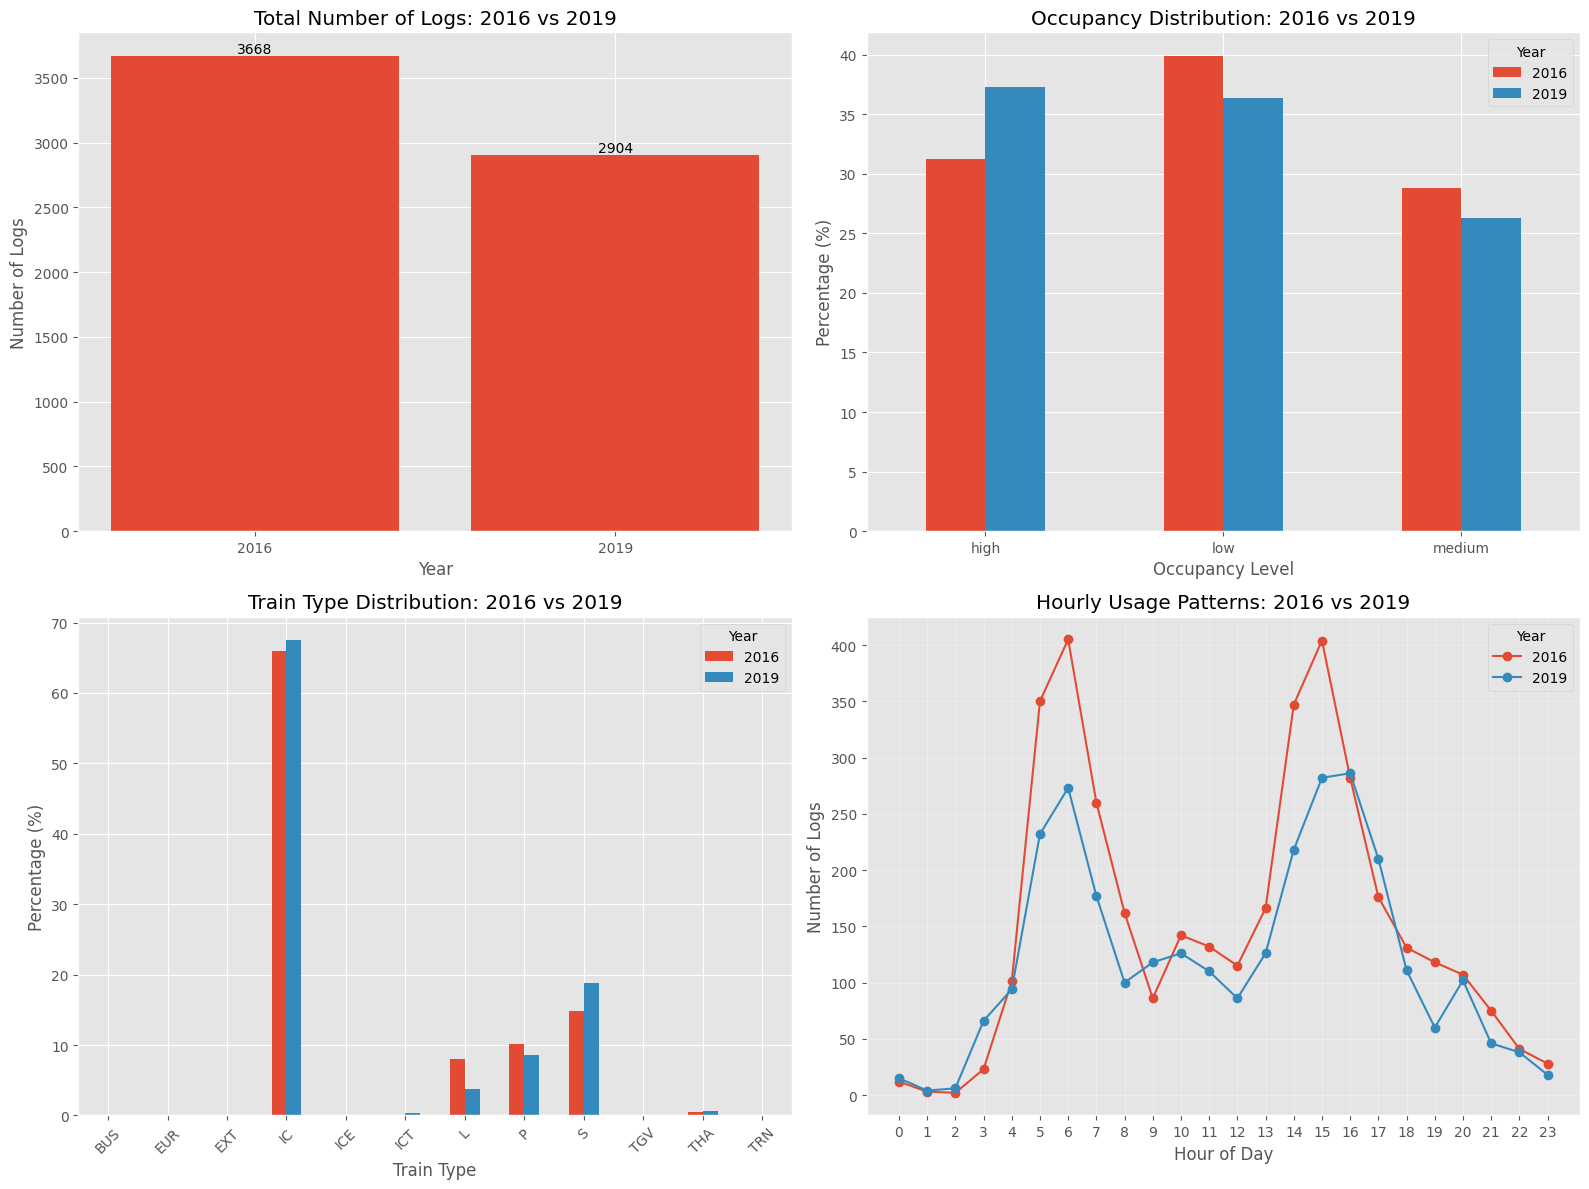

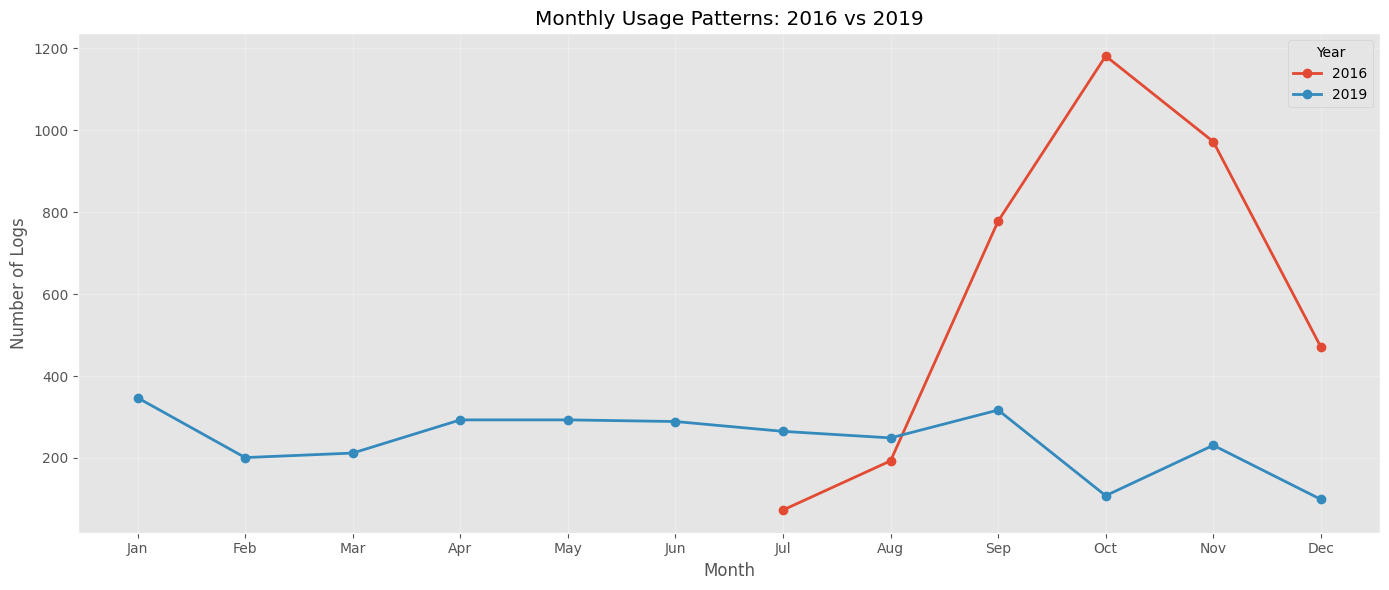

In [34]:
print("=== Comparison: 2016 vs 2019 ===\n")

# Add year column
df_with_year = df.withColumn('year', F.year('querytime'))

# Filter for 2016 and 2019
df_2016_2019 = df_with_year.filter(F.col('year').isin([2016, 2019]))

# 1. Total number of logs comparison
logs_per_year = (df_2016_2019.groupBy('year')
                 .count()
                 .orderBy('year')
                 .toPandas())

print("Total logs per year:")
print(logs_per_year)

# 2. Occupancy distribution comparison
occupancy_by_year = (df_2016_2019.groupBy('year', 'occupancy')
                     .count()
                     .toPandas())

pivot_occupancy = occupancy_by_year.pivot(index='year', columns='occupancy', values='count').fillna(0)
pivot_occupancy_norm = pivot_occupancy.div(pivot_occupancy.sum(axis=1), axis=0) * 100

print("\nOccupancy distribution (%):")
print(pivot_occupancy_norm)

# 3. Train type distribution comparison
traintype_by_year = (df_2016_2019.groupBy('year', 'train_type')
                     .count()
                     .toPandas())

pivot_traintype = traintype_by_year.pivot(index='year', columns='train_type', values='count').fillna(0)
pivot_traintype_norm = pivot_traintype.div(pivot_traintype.sum(axis=1), axis=0) * 100

print("\nTrain type distribution (%):")
print(pivot_traintype_norm)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total logs
axes[0, 0].bar(logs_per_year['year'].astype(str), logs_per_year['count'])
axes[0, 0].set_title('Total Number of Logs: 2016 vs 2019')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Logs')
for i, v in enumerate(logs_per_year['count']):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom')

# Plot 2: Occupancy comparison
pivot_occupancy_norm.T.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Occupancy Distribution: 2016 vs 2019')
axes[0, 1].set_xlabel('Occupancy Level')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Year')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# Plot 3: Train type comparison
pivot_traintype_norm.T.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Train Type Distribution: 2016 vs 2019')
axes[1, 0].set_xlabel('Train Type')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].legend(title='Year')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# Plot 4: Hourly patterns comparison
hourly_by_year = (df_2016_2019.withColumn('hour', F.hour('querytime'))
                  .groupBy('year', 'hour')
                  .count()
                  .toPandas())

for year in [2016, 2019]:
    data = hourly_by_year[hourly_by_year['year'] == year].sort_values('hour')
    axes[1, 1].plot(data['hour'], data['count'], marker='o', label=str(year))

axes[1, 1].set_title('Hourly Usage Patterns: 2016 vs 2019')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Logs')
axes[1, 1].legend(title='Year')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

# Monthly comparison
monthly_comparison = (df_2016_2019.withColumn('month', F.month('querytime'))
                      .groupBy('year', 'month')
                      .count()
                      .orderBy('year', 'month')
                      .toPandas())

plt.figure(figsize=(14, 6))
for year in [2016, 2019]:
    data = monthly_comparison[monthly_comparison['year'] == year]
    plt.plot(data['month'], data['count'], marker='o', linewidth=2, label=str(year))

plt.title('Monthly Usage Patterns: 2016 vs 2019')
plt.xlabel('Month')
plt.ylabel('Number of Logs')
plt.legend(title='Year')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

**4.3 Based on the above analysis, what information or which features would be good to use to predict future occupancy from the data that we have?**

Based on the comprehensive analysis comparing 2016 and 2019 data, the most important features for predicting future train occupancy are:
Top 5 Features:

* Hour of day - Shows consistent bimodal patterns with clear rush hour peaks at 6-8 AM and 5-7 PM in both years
* Day type (weekday/Saturday/Sunday) - Distinct patterns between weekdays (rush hours) and weekends (distributed usage)
* Train type - IC trains dominate (~66%) and different types serve different purposes
* Train series (route) - Specific routes show characteristic occupancy based on the regions they connect
* Is rush hour (derived) - Simplifies temporal patterns into actionable binary feature

**Supporting Features:**

* Train direction (away/back) - Morning vs evening flow patterns
* Month/season - Accounts for holidays and seasonal variations
* Station pairs - Popular connections have predictable demand
* Historical occupancy - Recent patterns are strong predictors

**Key Insight:** The 2016 vs 2019 comparison shows stable hourly and daily patterns despite a 26% decrease in log volume and a shift toward higher occupancy reporting (37% high in 2019 vs 31% in 2016). This stability suggests temporal and service-related features will generalize well for future predictions."

**4.4 Which stations would you suggest closing based on their usage?**

=== Station Usage Analysis for Potential Closure Recommendations ===

Bottom 20 Least Used Stations:
    station  from_count  to_count  total_usage
0   8841665           1         0            1
1   8832235           1         0            1
2   8811767           0         1            1
3   8008094           0         1            1
4   8811817           0         1            1
5   8200520           1         0            1
6   8812260           0         1            1
7   8400219           0         1            1
8   8814175           0         1            1
9   8714210           0         1            1
10  8814431           0         1            1
11  8775500           0         1            1
12  8821725           0         1            1
13  7015440           0         1            1
14  8822533           0         1            1
15  8400180           0         1            1
16  8824224           1         0            1
17  8731901           0         1            1
18  88

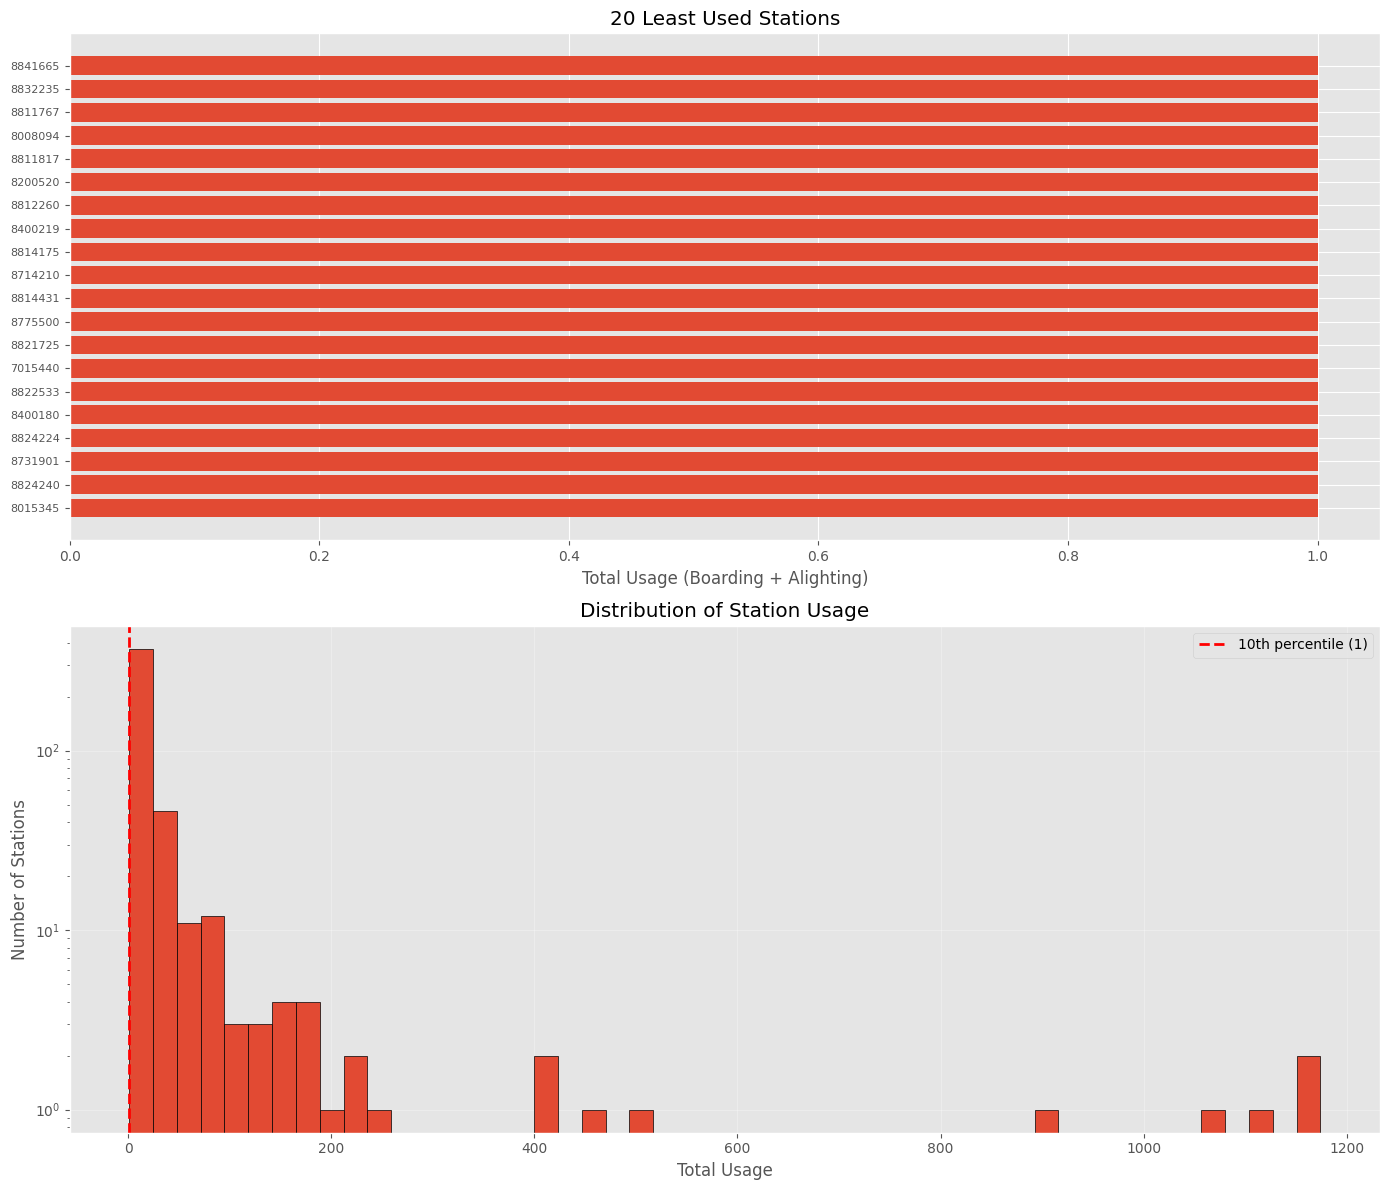


=== Temporal patterns for low-usage stations ===


In [35]:
print("=== Station Usage Analysis for Potential Closure Recommendations ===\n")

# Analyze station usage (both 'from' and 'to')
from_stations = df.groupBy('from').count().withColumnRenamed('count', 'from_count')
to_stations = df.groupBy('to').count().withColumnRenamed('count', 'to_count')

# Combine both directions
station_usage = (from_stations.join(to_stations, from_stations['from'] == to_stations['to'], 'outer')
                 .select(
                     F.coalesce('from', 'to').alias('station'),
                     F.coalesce('from_count', F.lit(0)).alias('from_count'),
                     F.coalesce('to_count', F.lit(0)).alias('to_count')
                 )
                 .withColumn('total_usage', F.col('from_count') + F.col('to_count'))
                 .orderBy('total_usage'))

# Get bottom 20 stations
bottom_stations = station_usage.limit(20).toPandas()

print("Bottom 20 Least Used Stations:")
print(bottom_stations)

# Calculate statistics
total_logs = df.count()
usage_stats = station_usage.toPandas()

print(f"\nTotal number of logs: {total_logs}")
print(f"Total unique stations: {len(usage_stats)}")
print(f"\nUsage Statistics:")
print(f"Mean usage per station: {usage_stats['total_usage'].mean():.2f}")
print(f"Median usage per station: {usage_stats['total_usage'].median():.2f}")
print(f"Minimum usage: {usage_stats['total_usage'].min()}")
print(f"Maximum usage: {usage_stats['total_usage'].max()}")

# Calculate threshold (e.g., bottom 10% or usage < 100)
threshold = usage_stats['total_usage'].quantile(0.10)
print(f"\n10th percentile threshold: {threshold:.2f}")

low_usage_stations = usage_stats[usage_stats['total_usage'] < threshold]
print(f"\nNumber of stations below 10th percentile: {len(low_usage_stations)}")

# Visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Bottom 20 stations
axes[0].barh(range(len(bottom_stations)), bottom_stations['total_usage'])
axes[0].set_yticks(range(len(bottom_stations)))
axes[0].set_yticklabels(bottom_stations['station'], fontsize=8)
axes[0].set_xlabel('Total Usage (Boarding + Alighting)')
axes[0].set_title('20 Least Used Stations')
axes[0].invert_yaxis()

# Plot 2: Distribution of station usage
axes[1].hist(usage_stats['total_usage'], bins=50, edgecolor='black')
axes[1].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'10th percentile ({threshold:.0f})')
axes[1].set_xlabel('Total Usage')
axes[1].set_ylabel('Number of Stations')
axes[1].set_title('Distribution of Station Usage')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Usage over time for low-usage stations
print("\n=== Temporal patterns for low-usage stations ===")

# Check if low-usage stations have seasonal patterns
if len(low_usage_stations) > 0:
    sample_low_stations = low_usage_stations.head(5)['station'].tolist()

    df_low_stations = df.filter(F.col('from').isin(sample_low_stations) |
                                 F.col('to').isin(sample_low_stations))

    monthly_pattern = (df_low_stations.withColumn('year_month', F.date_format('querytime', 'yyyy-MM'))
                       .groupBy('year_month')
                       .count()
                       .orderBy('year_month')
                       .toPandas())

    if len(monthly_pattern) > 0:
        plt.figure(figsize=(14, 6))
        plt.plot(monthly_pattern['year_month'], monthly_pattern['count'], marker='o')
        plt.title('Usage Pattern Over Time for Sample Low-Usage Stations')
        plt.xlabel('Month')
        plt.ylabel('Number of Logs')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Based on the data, I would suggest closing the 20 least used stations listed in the table, as each recorded only a single trip (total_usage = 1). These stations (e.g., 8841665, 8832235, 8811767, etc.) show negligible activity compared to the mean usage of 34.11 per station, indicating they provide minimal value to the network.

In [39]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Lab2_SparkEDA_TrainOccupancy2025_withData/SparkEDA_TrainOccupancy2025.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Lab2_SparkEDA_TrainOccupancy2025_withData/SparkEDA_TrainOccupancy2025.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 18 image(s).
[NbConvertApp] Writing 1695351 bytes to /content/drive/MyDrive/Colab Notebooks/Lab2_SparkEDA_TrainOccupancy2025_withData/SparkEDA_TrainOccupancy2025.html
